In [2]:
## Packages
'''Import all the necessary packages and modules'''

import numpy as np # package for playing with matrices
from scipy import signal as ss
import matplotlib.pyplot as plt
import sys, os # python modules for interacting with computer
from tkinter import filedialog # interface for opening a file explorer
from tkinter import * # * imports all files in tkinter 
import pandas as pd # useful for keeping cell structure and 2d data manipulation
import glob # helps find path 

In [3]:
## Functions
''' Run cell to use functions'''
def normalize(raw):
    norm=[]
    for i in raw:
        if i<0:
            norm.append(-i/min(raw))
        elif i>0:
            norm.append(i/max(raw))
        else:
            norm.append(i)
    return norm
def lowpass_filter(YA,sample_range,filter_size): #YA data set, measured sample range, filter_size arbitrary frequency cutoff based on number of samples
                   
    r=YA.shape[0]                   
    s=sample_range #GHz
    z=np.fft.fftfreq(r)/(2*s)*r
    B=filter_size
    e=int((B)/z[1])
    t=np.linspace(0, s, r)

    fYA=np.fft.rfft(YA)
    filter_e=e
    fYAr=np.zeros(fYA.shape[0])
    fYAl=np.zeros(fYA.shape[0])
    fYAr[:filter_e]=np.real(fYA[:filter_e])
    fYAl[:filter_e]=np.imag(fYA[:filter_e])
    fYA_filt=np.array(fYAr)+np.array(1j*fYAl)
    ifY=np.fft.irfft(fYA_filt)
    return ifY

def list_around(X,rang): # X is a number rang is the range around e.g X=8 rang=2 => list [6,7,8,9,10]
    lis=list(range(int(X)-int(rang),int(X)+int(rang)))
    
    return lis

def log10mean(X, axis):
    L=10* np.log10(np.mean((10**(X/10)),axis=axis))
    return L
def log10perdiff(X,Y):
    P = 100*((10**(X/10)-10**(Y/10))/((10**(X/10)+10**(Y/10))/2))
    return P
def log10perdiff1(X,Y):
    P = 10*np.log10(10**((X-Y)/10))
    return P
def log10div(X,Y):
    if X>=0:
        D = 10*np.log10(10**(X/10)/Y)
    else:
        D=10*np.log10((1-10**(X/10))/Y)
    return D
def log10add(X,Y):
    A = 10*np.log10(10**(X/10)+10**(Y/10))
    return A
def todB(X):
    d=10*np.log10(X)
    return d
def dBtonum(X):
    N = 10**(X/10)
    return N

In [4]:
## Data Directory GUI - Choose DC data
'''Getting data directory so data can easily be imported 
using this format data = hs.load('*.dm3', stack=True) to import all dm3s in folder as a stack'''

root = Tk() # Tk() is a function in tkinter that opens a window
root.directory = filedialog.askdirectory() # opens explorer window so you can find the folder of choice
#root.file = fieldialog.askopenfilename()
root.withdraw() # closes the tkinter window since it's unnecessary
oldcwd = os.getcwd() # saves old called working directory (place where data is drawn from) as oldcwd use os.chdir(oldcwd) to go back
os.chdir(root.directory) # sets new directory
newcwd = os.getcwd() # saves new directory name as newcwd
path = root.directory + '/*.csv' # creates path to data set folder directory. Change .csv to file type as needed
a=0 # counter for looping through list starting at 0
file_list=glob.glob(path)
file_list

['E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCombs_baseline/TEMCombs_baseline/Converted to csv\\Cable1.csv',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCombs_baseline/TEMCombs_baseline/Converted to csv\\Cable2.csv',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCombs_baseline/TEMCombs_baseline/Converted to csv\\Port1A.csv',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCombs_baseline/TEMCombs_baseline/Converted to csv\\Port1B.csv',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCombs_baseline/TEMCombs_baseline/Converted to csv\\Port2A.csv',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCombs_baseline/TEMCombs_baseline/Converted to csv\\Port2B.csv',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCombs_baseline/TEMCombs_baseline/Converted to csv\\Port3A.csv',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCombs_baseline/TEMCombs_baseline/Converted to csv\\Port3B.csv',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCombs_baseline/TEMCombs_baseline/Converted to c

In [5]:
## Load Data  use for .csv data
''' Open data and set up for analysis'''

num_files = np.size(file_list) # number of files in the directory with the correct file type
file_shape = np.array(pd.read_csv(glob.glob(path)[0]).values.shape) # data file size
Header = 4 #Removes string header to work with numpy array
file_shape[0]=file_shape[0]-Header # new file shape after removal of header
matrix_shape = np.append(file_shape, num_files) # size of matrix to hold all data
data_array = np.empty(matrix_shape) # builds empty matrix of size matrix_shape
for fname in file_list: #iterates through files along order of glob.glob(path)

    data = pd.read_csv(fname) # uses pandas to open files and keep structure
    data=data.drop(data.index[0:Header]) #Removes rows of header
    datapd = data.values # converts from dataframe to numpy array
    
    data_array[:,:,a] = datapd # inserts each file as new layer of matrix along z axis (axis=2)
    a+=1 # increase counter to progress through list
    

In [6]:
## Curate DC chip data before plotting
''' Separates data into new matrixes between A-no chip and B-with chip. Also applies filter'''

for_counter = np.arange(2,num_files-2,2)
a=0
num_cables=7
new_file_shape1=file_shape[1]-1
new_file_shape=np.append(file_shape[0]-1,new_file_shape1)
new_file_shape_orig=np.append(file_shape[0],new_file_shape1)
cable_data_matrix = np.append(new_file_shape,num_cables)
cable_data_matrix_orig = np.append(new_file_shape_orig,num_cables)
data_Ac_1=np.empty(cable_data_matrix)  #preallocates matrix size
data_Ac_1_orig=np.empty(cable_data_matrix_orig)
data_Bc_1=np.empty(cable_data_matrix)
data_Bc_1_orig=np.empty(cable_data_matrix_orig)
data_A_1=np.empty(cable_data_matrix)
data_A_1_orig=np.empty(cable_data_matrix_orig)
data_A_2=np.empty(cable_data_matrix)
data_A_2_orig=np.empty(cable_data_matrix_orig)
data_B_1=np.empty(cable_data_matrix)
data_B_1_orig=np.empty(cable_data_matrix_orig)
data_B_holder1=np.empty(cable_data_matrix)
data_B_holder1_orig=np.empty(cable_data_matrix_orig)
data_B_2=np.empty(cable_data_matrix)
data_B_2_orig=np.empty(cable_data_matrix_orig)


for counter in for_counter:
    
    data_Ac_1[:,0,a]=data_array[:-1,0,counter] # Cable x data
    data_Ac_1_orig[:,0,a]=data_array[:,0,counter] # Orig Cable x data
    
    data_Ac_1[:,1,a]=lowpass_filter(data_array[:,1,counter],9,3) # Cable y data
    data_Ac_1_orig[:,1,a]=data_array[:,1,counter] # Orig Cable y data
    
    data_A_1[:,0,a]=data_array[:-1,0,counter] # Cable1 and holder for A series x data   
    data_A_1_orig[:,0,a]=data_array[:,0,counter] # Cable1 and holder for A series x data 
    
    data_A_2[:,0,a]=data_array[:-1,0,counter] # Cable2 and holder for A series x data
    data_A_2_orig[:,0,a]=data_array[:,0,counter] # Cable2 and holder for A series x data  
    
    data_A_1[:,1,a]=lowpass_filter(data_array[:,1,counter],9,3)-lowpass_filter(data_array[:,1,0],9,3) # Holder-Cable1 for A series y data 
    data_A_1_orig[:,1,a]=data_array[:,1,counter]-data_array[:,1,0] # Orig Holder-Cable1 for A series y data 
    
    data_A_2[:,1,a]=lowpass_filter(data_array[:,1,counter],9,3)-lowpass_filter(data_array[:,1,1],9,3) # Holder-Cable2 for A series y data 
    data_A_2_orig[:,1,a]=data_array[:,1,counter]-data_array[:,1,1] # Orig Holder-Cable1 for A series y data 
    
    data_B_1[:,0,a]=data_array[:-1,0,counter+1] # Cable1 and holder for A series x data  
    data_B_1_orig[:,0,a]=data_array[:,0,counter+1] # Orig Cable1 and holder for A series x data 
    
    data_B_2[:,0,a]=data_array[:-1,0,counter+1] # Cable2 and holder for A series x data
    data_B_2_orig[:,0,a]=data_array[:,0,counter+1] # Cable2 and holder for A series x data
    
    data_B_1[:,1,a]=lowpass_filter(data_array[:,1,counter+1],9,3)-lowpass_filter(data_array[:,1,0],9,3) # Holder-Cable1 for A series y data 
    data_B_1_orig[:,1,a]=data_array[:,1,counter+1]-data_array[:,1,0] # Orig Holder-Cable1 for A series y data 
    
    data_B_holder1[:,1,a]=lowpass_filter(data_array[:,1,counter+1],9,3) # Holder-Cable1 for A series y data 
    data_B_holder1_orig[:,1,a]=data_array[:,1,counter+1] # Orig Holder-Cable1 for A series y data    
    
    data_B_2[:,1,a]=lowpass_filter(data_array[:,1,counter+1],9,3)-lowpass_filter(data_array[:,1,1],9,3) # Holder-Cable2 for A series y data 
    data_B_2_orig[:,1,a]=data_array[:,1,counter+1]-data_array[:,1,1] # Orig Holder-Cable2 for A series y data 
    
    a+=1

In [7]:
## Plots DC chip data
''' Change indexes or A->B if you want to plot data from no chip-> with chip. Also change from cable 1 to 2 and the naming.
Only took data of all the samples with Cable 1. Just took background of Cable 2'''
plot_file=np.arange(0,7)

data_array_order=[2,4,6,8,10,12,14] #Used for plotting A experiments
data_array_order1=[3,5,7,9,11,13,15] #Used for plotting B experiments

data_dc=np.zeros(cable_data_matrix_orig)
data_dc_filt=np.zeros(cable_data_matrix)

Ax_orig=np.zeros(data_A_1_orig.shape[0::2])
Ax_filt=np.zeros(data_A_1.shape[0::2])

Ay_orig=np.zeros(data_A_1_orig.shape[0::2])
Ay_filt=np.zeros(data_A_1.shape[0::2])

Bx_orig=np.zeros(data_B_1_orig.shape[0::2])
Bx_filt=np.zeros(data_B_1.shape[0::2])

By_orig=np.zeros(data_B_1_orig.shape[0::2])
By_filt=np.zeros(data_B_1.shape[0::2])

By_orig_holder=np.zeros(data_B_holder1_orig.shape[0::2]) #Raw Holder Data
By_filt_holder=np.zeros(data_B_holder1.shape[0::2]) #Raw Holder Data

as_meas_orig=np.zeros(data_A_1_orig.shape[0::2])
as_meas_filt=np.zeros(data_A_1.shape[0::2])

cable_orig=np.zeros(data_A_1_orig.shape[0::2])
cable_filt=np.zeros(data_A_1.shape[0::2])

for n in plot_file:
    
    X=data_A_1[:,0,plot_file[n]]/1e9; #Used for plotting B experiments as data_B_R, R=1,2
    X_orig=data_A_1_orig[:,0,plot_file[n]]/1e9; #Used for plotting B experiments as data_B_R, R=1,2
    X1=data_B_1[:,0,plot_file[n]]/1e9; #Used for plotting B experiments as data_B_R, R=1,2
    X1_orig=data_B_1_orig[:,0,plot_file[n]]/1e9; #Used for plotting B experiments as data_B_R, R=1,2
    Ax_orig[:,n]=X_orig;
    Ax_filt[:,n]=X;
    
    Bx_orig[:,n]=X1_orig;
    Bx_filt[:,n]=X1;
    
    YA=data_A_1[:,1,plot_file[n]]; 
    YA_orig=data_A_1_orig[:,1,plot_file[n]]; 
    
    Ay_orig[:,n]=YA_orig; #Capture all the holder and chip data
    Ay_filt[:,n]=YA; #Capture all the holder and chip data filtered
    
    YB=data_B_1[:,1,plot_file[n]];
    YB_orig=data_B_1_orig[:,1,plot_file[n]];
    
    YB_holder=data_B_holder1[:,1,plot_file[n]];
    YB_orig_holder=data_B_holder1_orig[:,1,plot_file[n]];
    
    By_orig[:,n]=YB_orig; # Capture all the just holder data
    By_filt[:,n]=YB; # Capture all just holder and filtered
    
    By_orig_holder[:,n]=YB_orig_holder; # Capture all the just holder data
    By_filt_holder[:,n]=YB_holder; # Capture all just holder and filtered
    
    y1c=data_Ac_1[:,1,plot_file[n]];
    y1c_orig=data_Ac_1_orig[:,1,plot_file[n]];
    
    as_meas_orig[:,n]=y1c_orig;
    as_meas_filt[:,n]=y1c;
    
    y1=lowpass_filter(data_array[:,1,0],9,3); #0 for cable 1 and 1 for cable 2 in the z position
    y1_orig=data_array[:,1,0]; #0 for cable 1 and 1 for cable 2 in the z position
    
    cable_orig[:,n]=y1_orig;
    cable_filt[:,n]=y1;
#     Y=YA-YB 
#     Y_orig=YA_orig-YB_orig
    
    data_dc[:,0,n]=X_orig
    data_dc_filt[:,0,n]=X
    
    data_dc[:,1,n]=YB_orig
    data_dc_filt[:,1,n]=YB


In [8]:
## Data Directory GUI - Choose RF data
'''Getting data directory so data can easily be imported 
using this format data = hs.load('*.dm3', stack=True) to import all dm3s in folder as a stack'''

root1 = Tk() # Tk() is a function in tkinter that opens a window
root1.directory = filedialog.askdirectory() # opens explorer window so you can find the folder of choice
#root.file = fieldialog.askopenfilename()
root1.withdraw() # closes the tkinter window since it's unnecessary
oldcwd1 = os.getcwd() # saves old called working directory (place where data is drawn from) as oldcwd use os.chdir(oldcwd) to go back
os.chdir(root1.directory) # sets new directory
newcwd1 = os.getcwd() # saves new directory name as newcwd
path1 = root1.directory + '/*.s1p' # creates path to data set folder directory. Change .csv to file type as needed
path2 = root1.directory + '/*.csv' # creates path to data set folder directory. Change .csv to file type as needed

file_list1=glob.glob(path1)
file_list1.insert(8,glob.glob(path2)[0])
file_list1

['E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\CableBaseline.s1p',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Chip1Port1.s1p',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Chip1Port2.s1p',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Chip1Port3.s1p',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Chip1Port4.s1p',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Chip1Port5.s1p',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Chip1Port6.s1p',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Chip1Port7.s1p',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Chip2Port1.csv',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Chip2Port2.s1p',
 'E:/Users/kbs1/Documents/TEMCarrier Data OLD/TEMCarrierApr2018/Originals\\Ch

In [9]:
## Load Data use for .s1p data Load RF data
''' Open data and set up for analysis'''

num_files1 = np.size(file_list1) # number of files in the directory with the correct file type
Header1 = 4 #Removes string header to work with numpy array
file_shape1 = np.array(pd.read_csv(glob.glob(path1)[0],delim_whitespace=True, header=Header1).values.shape) # data file size
file_shape1[1]=file_shape[1]
matrix_shape1 = np.append(file_shape1, num_files1) # size of matrix to hold all data
data_array1 = np.empty(matrix_shape1) # builds empty matrix of size matrix_shape
a1=0 # counter for looping through list starting at 0
for fname in file_list1: #iterates through files along order of glob.glob(path)

    if fname == glob.glob(path2)[0]:
#         print(a1)
        data = pd.read_csv(file_list1[8], header=Header+3)
#         datapd=np.tile(data,2)
        data_array1[:,:,a1] = datapd # inserts each file as new layer of matrix along z axis (axis=2)
        a1+=1 # increase counter to progress through list
    else:
    
        data = pd.read_csv(fname, delim_whitespace=True, header=Header) # uses pandas to open files and keep structure
        #data=data.drop(data.index[END-Header:END]) #Removes rows of header
        datapd = data.values[:,0:3] # converts from dataframe to numpy array
#         print(a1)
        data_array1[:,:,a1] = datapd # inserts each file as new layer of matrix along z axis (axis=2)
        a1+=1 # increase counter to progress through list
    

In [10]:
## RF data plotting
''' Opens all RF samples and subtracts cable results. Also plots filtered data'''
plot_file1=np.arange(data_array1.shape[2])

size1=(data_array1[:,1,0].shape[0], plot_file1.shape[0])
size2=(data_array1[:-1,1,0].shape[0], plot_file1.shape[0])
rfx_orig=data_array1[:,0,0]/1e9
rfx_filt=data_array1[:-1,0,0]/1e9

rfy_orig=np.zeros(size1)
rfy_filt=np.zeros(size2)


for n in plot_file1:
  
    #X=data_A_2[:,0,plot_file[n]] #Used for plotting A experiments as data_A_R, R=1,2
    #Y=data_A_2[:,1,plot_file[n]] #Used for plotting A experiments as data_A_R, R=1,2
    x_cable2=data_array1[:,0,0]/1e9
    y_cable2=data_array1[:,1,0]
    y_cable2_filt=lowpass_filter(y_cable2,9,3)
    
    x_orig2=data_array1[:,0,n]/1e9
    y_orig2=data_array1[:,1,n]
    #x_filt=data_array[:,0,n] #Used for plotting B experiments as data_B_R, R=1,2
    y_orig2_filt=lowpass_filter(y_orig2,9,3) #Used for plotting B experiments as data_B_R, R=1,2
    
    Y_holder2=y_orig2-y_cable2
    Y_holder2_filt= y_orig2_filt-y_cable2_filt
    
    rfy_orig[:,n]=Y_holder2
    rfy_filt[:,n]=Y_holder2_filt


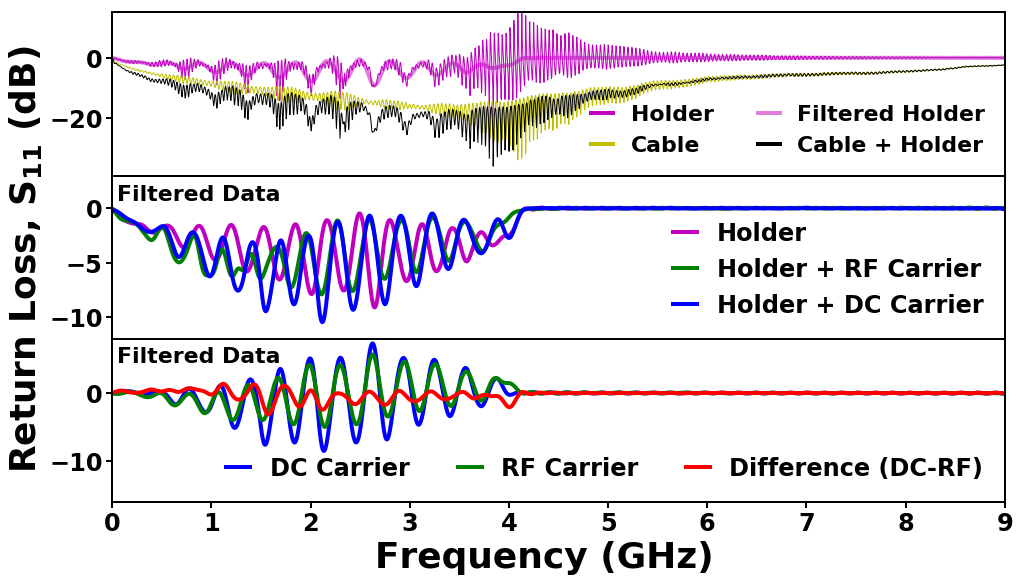

In [11]:
## Average Response

plt.rc('font', weight='bold')
plt.rcParams['axes.linewidth']=2
plt.rcParams['figure.figsize'] = (16,9)

# Three subplots sharing both x/y axes
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=False)

fig.text(0.5, 0.04, 'Frequency (GHz)', ha='center', va='center', fontsize=36, fontweight='bold')
fig.text(0.05, 0.5,r'Return Loss, S$_{11}$ (dB)', ha='center', va='center', rotation='vertical', fontsize=36, fontweight='bold')

# ax1.set_xlabel('Frequency (GHz)', fontsize=36, fontweight='bold')
# ax1.set_ylabel(r'S$_{11}$ (dB)', fontsize=36, fontweight='bold')
ax1.set_xlim(0,9)
ax1.set_ylim(-39,15)
    
ax1.tick_params(axis='both', which='major', labelsize=24, width=2, length=6)
ax1.tick_params(axis='both', which='minor', labelsize=24, width=2, length=6)

ax2.tick_params(axis='both', which='major', labelsize=24, width=2, length=6)
ax2.tick_params(axis='both', which='minor', labelsize=24, width=2, length=6)
ax2.set_ylim(-12,3)
ax2.set_xlim(0,9)
ax3.tick_params(axis='both', which='major', labelsize=24, width=2, length=6)
ax3.tick_params(axis='both', which='minor', labelsize=24, width=2, length=6)
ax3.set_ylim(-16,8)
ax3.set_xlim(0,9)
Ax_orig_mean=log10mean(Ax_orig,axis=1)
Ay_orig_mean=log10mean(Ay_orig,axis=1)

Ax_filt_mean=log10mean(Ax_filt,axis=1)
Ay_filt_mean=log10mean(Ay_filt,axis=1)

Bx_orig_mean=log10mean(Bx_orig,axis=1)
By_orig_mean=log10mean(By_orig,axis=1)
By_orig_mean_holder=log10mean(By_orig_holder,axis=1)

Bx_filt_mean=log10mean(Bx_filt,axis=1)
By_filt_mean=log10mean(By_filt,axis=1)
By_filt_mean_holder=log10mean(By_filt_holder,axis=1)

rfy_orig_mean=log10mean(rfy_orig, axis=1)
rfy_filt_mean=log10mean(rfy_filt, axis=1)

# dcy_diff=Ax_orig_mean-By_orig_mean; # isolate DCy
rfy_diff=rfy_orig_mean-By_orig_mean[::2]; # isolate rfy
rfy_diff_filt=lowpass_filter(rfy_orig_mean,9,3)-lowpass_filter(By_orig_mean[::2],9,3); # isolate rfy

dcrf_diff=Ay_orig_mean[::2]-rfy_orig_mean; # DC-RFy
dcrf_diff_filt=lowpass_filter(Ay_orig_mean[::2],9,3)-lowpass_filter(rfy_orig_mean,9,3); # DC-RFy


as_meas_orig_mean=log10mean(as_meas_orig, axis=1)
as_meas_filt_mean=log10mean(as_meas_filt, axis=1)

Diff_orig_mean=Ay_orig_mean-By_orig_mean
diff_orig_mean=log10perdiff1(Ay_orig_mean,By_orig_mean)
Diff_filt_mean=Ay_filt_mean-By_filt_mean

cable_orig_mean=log10mean(cable_orig, axis=1)
cable_filt_mean=log10mean(cable_filt, axis=1)
lin_size=4
lin_size1=1

alph=.5
# Ay_orig_mean_filt=lowpass_filter(Ay_orig_mean,5,3)
ax1.plot(Bx_orig_mean,By_orig_mean,'m-',linewidth=lin_size1, label='Holder') # Holder
ax1.plot(X_orig,cable_orig_mean,'y-',linewidth=lin_size1, label='Cable')  #Cable
ax1.plot(Bx_filt_mean,By_filt_mean,'m-',linewidth=lin_size, label='Filtered Holder', alpha=alph) # Holder
ax1.plot(Bx_orig_mean,By_orig_mean_holder,'k-',linewidth=lin_size1, label='Cable + Holder')  #Without Carrier in place
# ax1.plot(Bx_orig_mean,as_meas_orig_mean,'y-',linewidth=lin_size1, label='As Measured') # As measured  

# ax1.plot(Ax_orig_mean,Ay_orig_mean,'b-',linewidth=lin_size1, label='With DC Carrier')  #With carrier in place

# ax2.plot(Ax_orig_mean,Ay_orig_mean,'b-',linewidth=lin_size1, alpha=alph)  #With carrier in place
# ax2.plot(rfx_orig,rfy_orig_mean,'g-',linewidth=lin_size1, alpha=alph)  #With carrier in place


# ax3.plot(rfx_orig,rfy_diff,'b-',linewidth=lin_size1, label='RF')  #With carrier in place
# ax3.plot(Bx_orig_mean,Diff_orig_mean,'r-',linewidth=lin_size1, label='DC')  #With carrier in place
# ax3.plot(rfx_orig,dcrf_diff,'k-',linewidth=lin_size1, label='DC-RF')  #Without Carrier in place


ax3.plot(Bx_filt_mean,Diff_filt_mean,'b-',linewidth=lin_size, label='DC Carrier')  #With carrier in place
ax3.plot(rfx_orig[:-1],rfy_diff_filt,'g-',linewidth=lin_size, label='RF Carrier')  #With carrier in place
ax3.plot(rfx_orig[:-1],dcrf_diff_filt,'r-',linewidth=lin_size, label='Difference (DC-RF)')  #Without Carrier in place
# ax3.plot(Bx_orig_mean,diff_orig_mean,'b-',linewidth=lin_size1, label='DC')  #With carrier in place

ax2.plot(Bx_filt_mean,By_filt_mean,'m-',linewidth=lin_size, label='Holder') # Holder
ax2.plot(rfx_filt,rfy_filt_mean,'g-',linewidth=lin_size, label='Holder + RF Carrier') 
ax2.plot(Ax_filt_mean,Ay_filt_mean,'b-',linewidth=lin_size,label='Holder + DC Carrier')  

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)

     
leg=ax1.legend(fontsize=22, loc='best', frameon=False, handlelength=1,ncol=2)   
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)
    
leg=ax2.legend(fontsize=24, loc=4, frameon=False, handlelength=1)   
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)
    
leg=ax3.legend(fontsize=24, loc=4, frameon=False, handlelength=1, ncol=3)   
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)
    
fig.text(0.2, 0.6,'Filtered Data', ha='center', va='center', fontsize=22, fontweight='bold');
fig.text(0.2, 0.35,'Filtered Data', ha='center', va='center', fontsize=22, fontweight='bold');

In [71]:
root2 = Tk(); # Tk() is a function in tkinter that opens a window
root2.directory = filedialog.askdirectory(); # opens explorer window so you can find the folder of choice
root2.withdraw(); # closes the tkinter window since it's unnecessary

In [77]:
file_name2='S11 Mean results_6frame'
ext2='.png'
file_loc2=root2.directory+'/'+file_name2+ext2
file_loc2

'Z:/Carrier Paper/Figure 3/S11 Mean results_6frame.png'

In [78]:
fig.savefig(file_loc2,dpi=600,bbox_inches='tight')

In [96]:
log10mean(By_orig_mean, axis=0)

-0.15809494512065558

In [94]:
-7.387061513255311/8

-0.9233826891569139